In [3]:
import os
import datetime
import argparse
from distutils.version import LooseVersion
# Numerical libs
import numpy as np
import torch
import torch.nn as nn
from scipy.io import loadmat
# Our libs
from dataset import TestDataset
from models import ModelBuilder, SegmentationModule
from utils import colorEncode
from lib.nn import user_scattered_collate, async_copy_to
from lib.utils import as_numpy, mark_volatile
import lib.utils.data as torchdata
import cv2
from broden_dataset_utils.joint_dataset import broden_dataset
from utils import maskrcnn_colorencode, remove_small_mat
import matplotlib.pyplot as plt
import cv2


/home/marcotcr/work/unifiedparsing/broden_dataset_utils/pascalseg.py:56: UserWarning: Error when searching for pascal part annotations, please check your dataset. With this error you may only use testing scripts. Training will fail unless you resolve this warning.
  warnings.warn(message)


Using /tmp/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /tmp/torch_extensions/_prroi_pooling/build.ninja...
Building extension module _prroi_pooling...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module _prroi_pooling...


In [4]:
from test import *

In [5]:
parser = argparse.ArgumentParser()
# Path related arguments
parser.add_argument('--test_img', required=True)
parser.add_argument('--model_path', required=True,
                    help='folder to model path')
parser.add_argument('--suffix', default='_epoch_40.pth',
                    help="which snapshot to load")

# Model related arguments
parser.add_argument('--arch_encoder', default='resnet50_dilated8',
                    help="architecture of net_encoder")
parser.add_argument('--arch_decoder', default='ppm_bilinear_deepsup',
                    help="architecture of net_decoder")
parser.add_argument('--fc_dim', default=2048, type=int,
                    help='number of features between encoder and decoder')

# Data related arguments
parser.add_argument('--num_val', default=-1, type=int,
                    help='number of images to evalutate')
parser.add_argument('--num_class', default=150, type=int,
                    help='number of classes')
parser.add_argument('--batch_size', default=1, type=int,
                    help='batchsize. current only supports 1')
parser.add_argument('--imgSize', default=[300, 400, 500, 600],
                    nargs='+', type=int,
                    help='list of input image sizes.'
                         'for multiscale testing, e.g. 300 400 500')
parser.add_argument('--imgMaxSize', default=1000, type=int,
                    help='maximum input image size of long edge')
parser.add_argument('--padding_constant', default=8, type=int,
                    help='maxmimum downsampling rate of the network')
parser.add_argument('--segm_downsampling_rate', default=8, type=int,
                    help='downsampling rate of the segmentation label')

# Misc arguments
parser.add_argument('--result', default='./',
                    help='folder to output visualization results')
parser.add_argument('--gpu_id', default=0, type=int,
                    help='gpu_id for evaluation')

args = parser.parse_args('--model_path upp-resnet50-upernet\
  --test_img ADE_val_00000001.jpg \
  --arch_encoder resnet50 \
  --arch_decoder upernet \
  --result ./'.split())
print(args)

nr_classes = broden_dataset.nr.copy()
nr_classes['part'] = sum(
    [len(parts) for obj, parts in broden_dataset.object_part.items()])
args.nr_classes = nr_classes

# absolute paths of model weights
args.weights_encoder = os.path.join(args.model_path,
                                    'encoder' + args.suffix)
args.weights_decoder = os.path.join(args.model_path,
                                        'decoder' + args.suffix)


Namespace(arch_decoder='upernet', arch_encoder='resnet50', batch_size=1, fc_dim=2048, gpu_id=0, imgMaxSize=1000, imgSize=[300, 400, 500, 600], model_path='upp-resnet50-upernet', num_class=150, num_val=-1, padding_constant=8, result='./', segm_downsampling_rate=8, suffix='_epoch_40.pth', test_img='ADE_val_00000001.jpg')


In [6]:
# args.num_val

In [7]:
torch.cuda.set_device(args.gpu_id)

# Network Builders
builder = ModelBuilder()
net_encoder = builder.build_encoder(
    arch=args.arch_encoder,
    fc_dim=args.fc_dim,
    weights=args.weights_encoder)
net_decoder = builder.build_decoder(
    arch=args.arch_decoder,
    fc_dim=args.fc_dim,
    nr_classes=args.nr_classes,
    weights=args.weights_decoder,
    use_softmax=True)

segmentation_module = SegmentationModule(net_encoder, net_decoder)
segmentation_module.cuda();
segmentation_module.eval();


Loading weights for net_encoder
Loading weights for net_decoder


In [8]:
def visualize_result(data, preds, args):

    np.random.seed(233)
    color_list = np.random.rand(1000, 3) * .7 + .3

    # image
    img = data['img_ori']
    cv2.imwrite(os.path.join(args.result, "original_image.jpg"), img)

    # object
    object_result = preds['object']
    object_result_colored = maskrcnn_colorencode(img, object_result, color_list)
    cv2.imwrite(os.path.join(args.result, "object_result.png"), object_result_colored)

    # part
    img_part_pred, part_result = img.copy(), preds['part']
    valid_object = np.zeros_like(object_result)
    present_obj_labels = np.unique(object_result)
    for obj_part_index, object_label in enumerate(broden_dataset.object_with_part):
        if object_label not in present_obj_labels:
            continue
        object_mask = (object_result == object_label)
        valid_object += object_mask
        part_result_masked = part_result[obj_part_index] * object_mask
        present_part_label = np.unique(part_result_masked)
        if len(present_part_label) == 1:
            continue
        img_part_pred = maskrcnn_colorencode(
            img_part_pred, part_result_masked + object_mask, color_list)
    cv2.imwrite(os.path.join(args.result, "part_result.png"), img_part_pred)

    # scene
    print("scene shape: {}".format(preds['scene'].shape))
    scene_top5 = np.argsort(-preds['scene'])[:5]
    with open(os.path.join(args.result, "scene.txt"), 'w') as f:
        f.write("scene pred:\n")
        scene_info = ["{}({}) {:.4f}".format(
            l, broden_dataset.names['scene'][l], preds['scene'][l])
            for l in scene_top5]
        f.write("\n".join(scene_info))

    # material
    material_result = preds['material']
    img_material_result = maskrcnn_colorencode(
        img, remove_small_mat(material_result * (valid_object > 0), object_result), color_list)
    cv2.imwrite(os.path.join(args.result, "material_result.png"), img_material_result)


In [9]:
# Dataset and Loader
# list_test = [{'fpath_img': args.test_img}, {'fpath_img': 'kitchen-equipment.jpg'}]
list_test = [{'fpath_img': x} for x in ['man.jpg', 'tennis.jpg', 'dog.jpg', 'phone.jpg', 'food.jpg']]
dataset_val = TestDataset(
    list_test, args, max_sample=args.num_val)
loader_val = torchdata.DataLoader(
    dataset_val,
    batch_size=args.batch_size,
    shuffle=False,
    collate_fn=user_scattered_collate,
    num_workers=5,
    drop_last=True)
loader = loader_val

# samples: 5


In [10]:
print(len(broden_dataset.names['object']))

336


In [12]:
apreds = []
confs = []
imgs = []
threshold = 0.3
for i, data in enumerate(loader):
        data = data[0]
        seg_size = data['img_ori'].shape[0:2]

        with torch.no_grad():
            pred_ms = {}
            conf_ms = {}
            for k in ['object', 'material']:
                pred_ms[k] = torch.zeros(1, args.nr_classes[k], *seg_size)
                conf_ms[k] = torch.zeros(1, args.nr_classes[k], *seg_size)
            pred_ms['part'] = []
            conf_ms['part'] = []
            for idx_part, object_label in enumerate(broden_dataset.object_with_part):
                n_part = len(broden_dataset.object_part[object_label])
                pred_ms['part'].append(torch.zeros(1, n_part, *seg_size))
                conf_ms['part'].append(torch.zeros(1, n_part, *seg_size))
            pred_ms['scene'] = torch.zeros(1, args.nr_classes['scene'])

            for img in data['img_data']:
                # forward pass
                feed_dict = async_copy_to({"img": img}, args.gpu_id)
                pred = segmentation_module(feed_dict, seg_size=seg_size)
                for k in ['scene', 'object', 'material']:
                    pred_ms[k] = pred_ms[k] + pred[k].cpu() / len(args.imgSize)
#                     pred_ms[k][0][0] = threshold
                for idx_part, object_label in enumerate(broden_dataset.object_with_part):
                    pred_ms['part'][idx_part] += pred['part'][idx_part].cpu() / len(args.imgSize)

            pred_ms['scene'] = pred_ms['scene'].squeeze(0)
            for k in ['object', 'material']:
                c_max, p_max = torch.max(pred_ms[k].cpu(), dim=1)
                pred_ms[k] = p_max.squeeze(0)
                conf_ms[k] = c_max.squeeze(0)
            for idx_part, object_label in enumerate(broden_dataset.object_with_part):
                c_max, p_max = torch.max(pred_ms['part'][idx_part].cpu(), dim=1)
                pred_ms['part'][idx_part] = p_max.squeeze(0)
                conf_ms['part'][idx_part] = c_max.squeeze(0)
            pred_ms = as_numpy(pred_ms)
            conf_ms = as_numpy(conf_ms)
            apreds.append(pred_ms)
            confs.append(conf_ms)
            imgs.append(data['img_ori'])

#         visualize_result(data, pred_ms, args)

        print('[{}] iter {}'
              .format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), i))



[2020-07-21 15:24:40] iter 0
[2020-07-21 15:24:42] iter 1
[2020-07-21 15:24:43] iter 2
[2020-07-21 15:24:46] iter 3
[2020-07-21 15:24:49] iter 4


In [17]:
i = 0 
preds = apreds[i]
img = imgs[i]
conf = confs[i]
# preds = preds_ms
color_list = np.random.rand(1000, 3) * .7 + .3
# img = data['img_ori']
# object_result_colored = maskrcnn_colorencode(img, object_result, color_list)


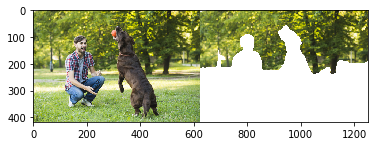

In [40]:
plt.imshow(np.concatenate((img_np, b), axis=1))

<Figure size 576x576 with 0 Axes>

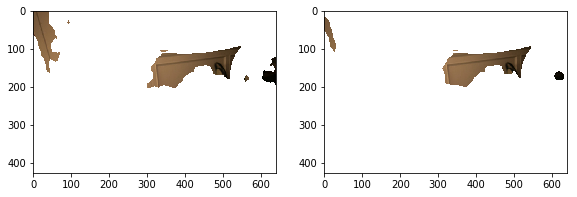

In [56]:
fig=plt.figure(figsize=(20, 10))
fig.add_subplot(1, 4, 1)
plt.imshow(bs[0]);
fig.add_subplot(1, 4, 2)
plt.imshow(bs[1]);
plt.show()

In [50]:
plt.show(fig)

tree 0.5% 0.4% 0.4%


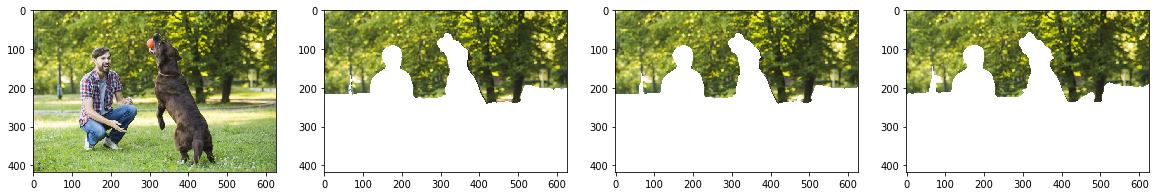

person 0.1% 0.1% 0.1%


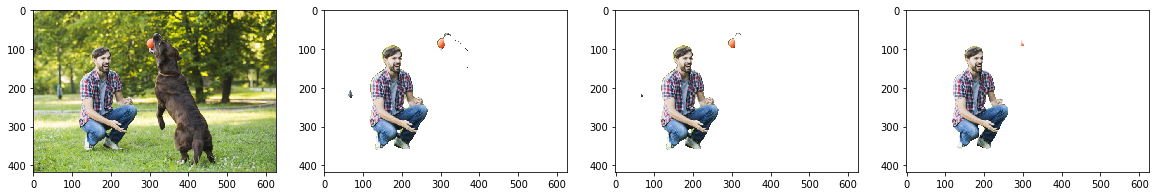

grass 0.4% 0.4% 0.3%


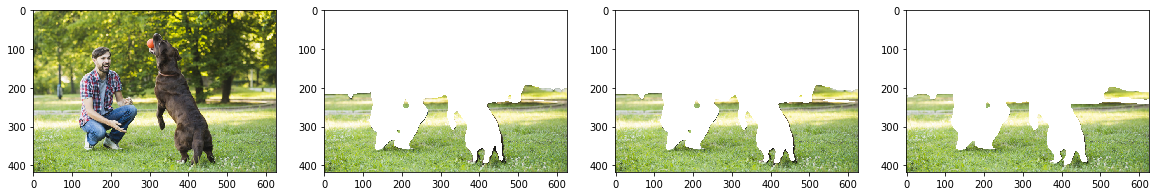

dog 0.1% 0.1% 0.0%


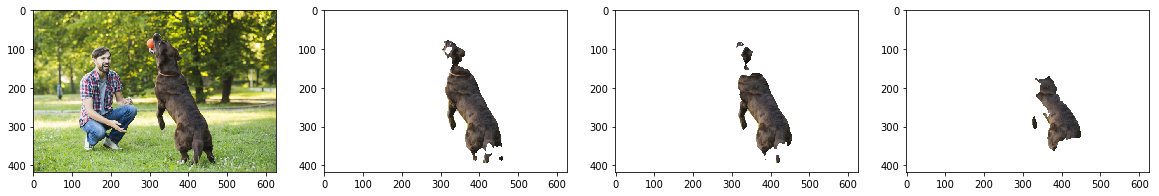



person 0.4% 0.3% 0.2%


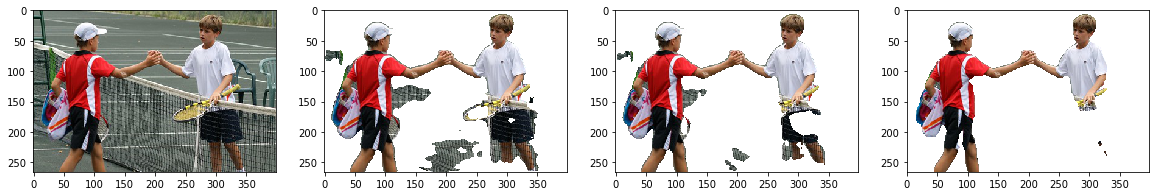

road 0.4% 0.3% 0.2%


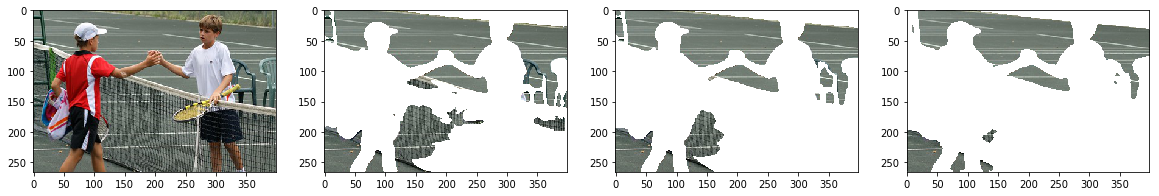



sky 0.3% 0.3% 0.3%


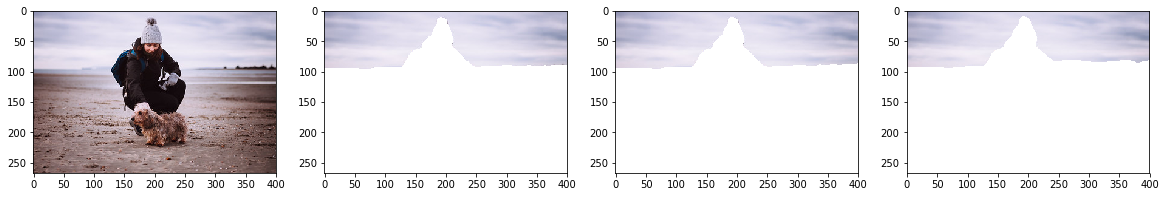

person 0.1% 0.1% 0.1%


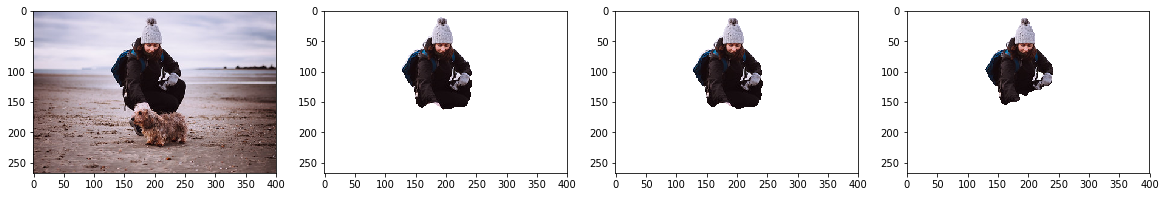

dog 0.0% 0.0% 0.0%


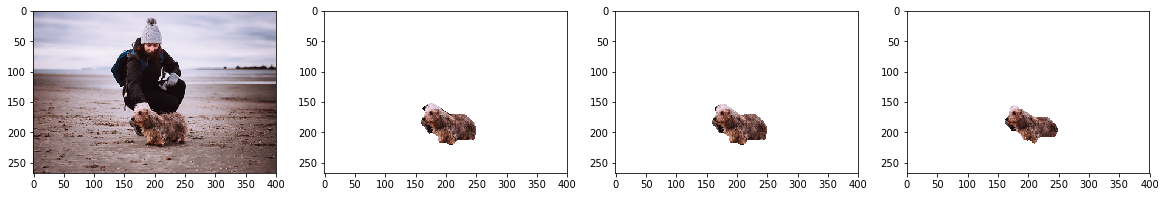

sand 0.5% 0.5% 0.5%


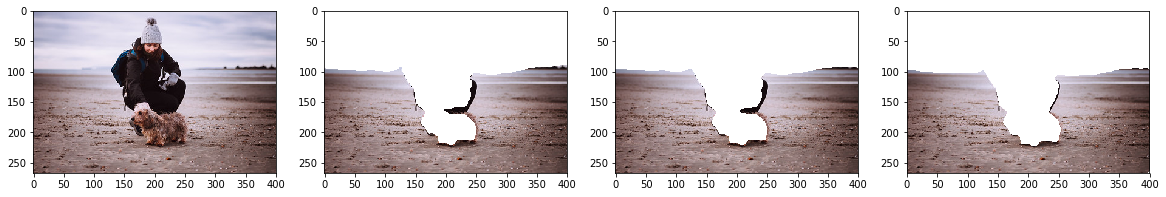



tree 0.1% 0.1% 0.0%


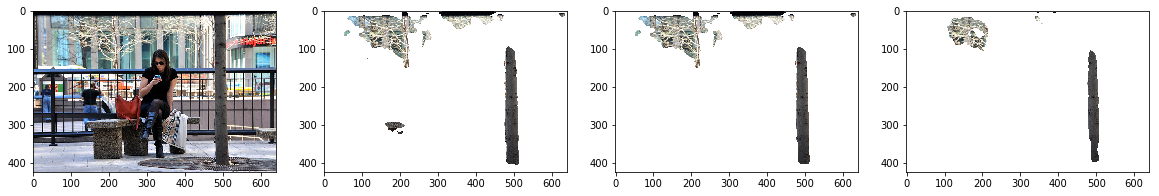

building 0.4% 0.3% 0.2%


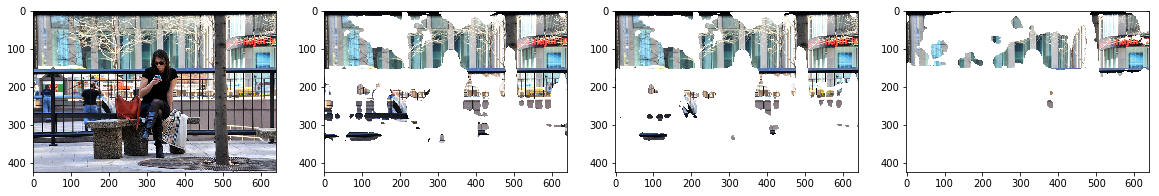

person 0.1% 0.1% 0.1%


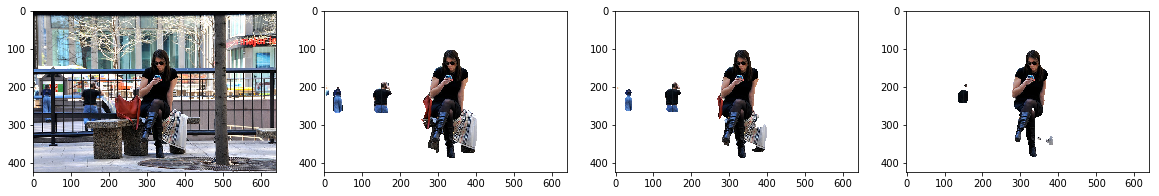

ground 0.2% 0.1% 0.0%


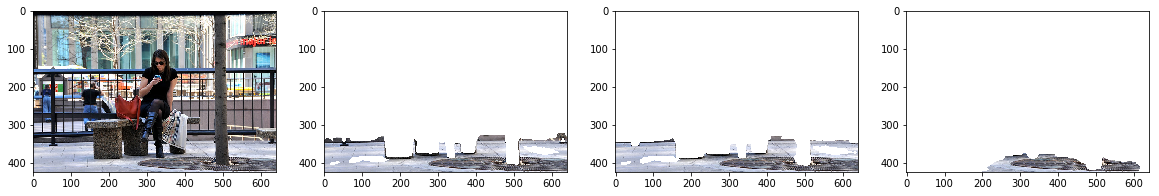

fence 0.2% 0.1% 0.0%


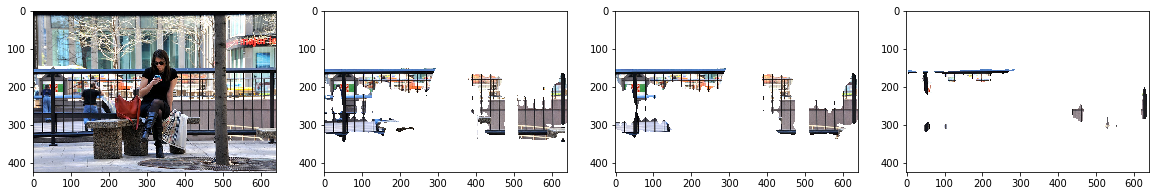



wall 0.1% 0.1% 0.0%


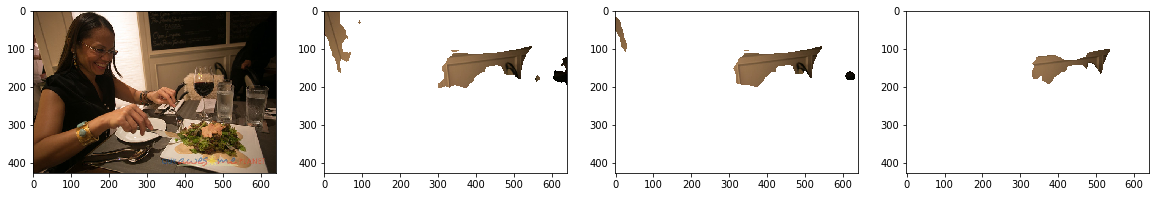

person 0.4% 0.3% 0.3%


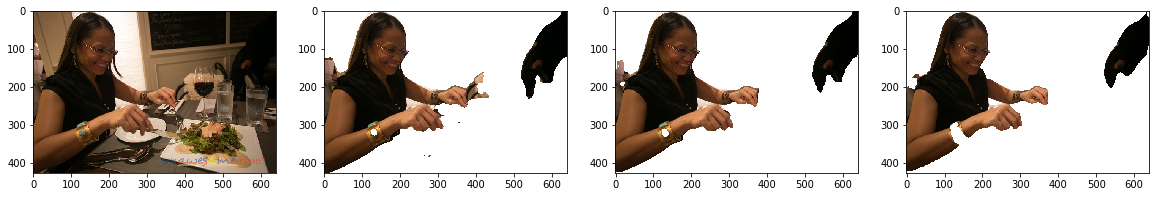

table 0.2% 0.1% 0.1%


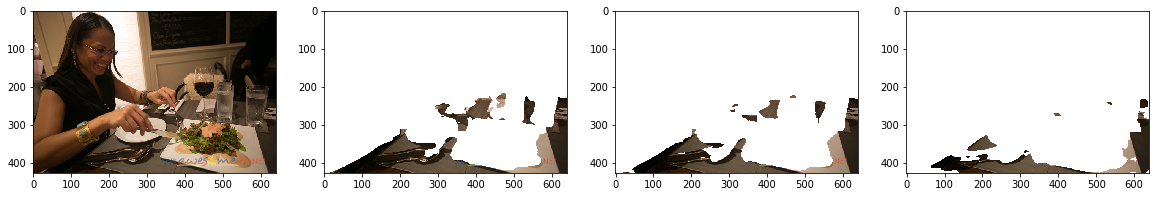

window 0.2% 0.2% 0.1%


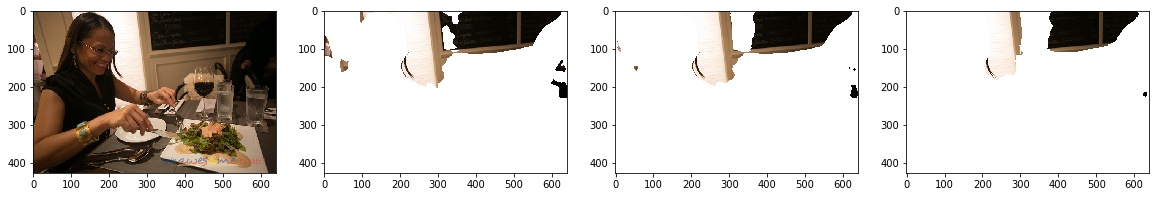

plate 0.1% 0.0% 0.0%


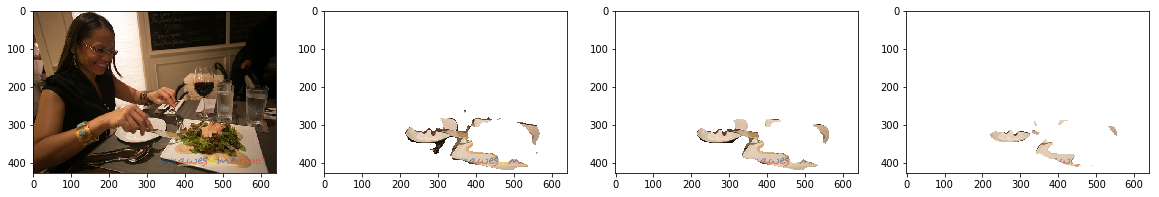

food 0.1% 0.1% 0.0%


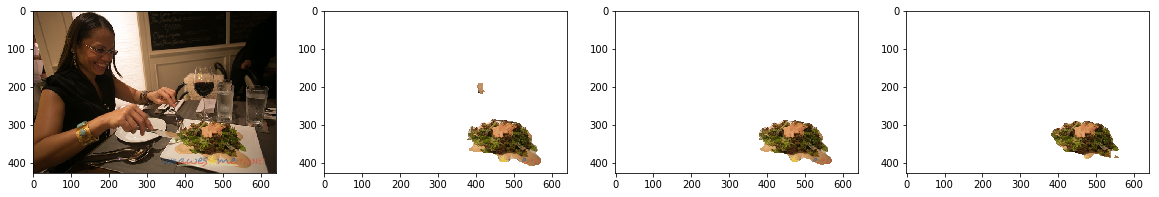

wineglass 0.0% 0.0% 0.0%


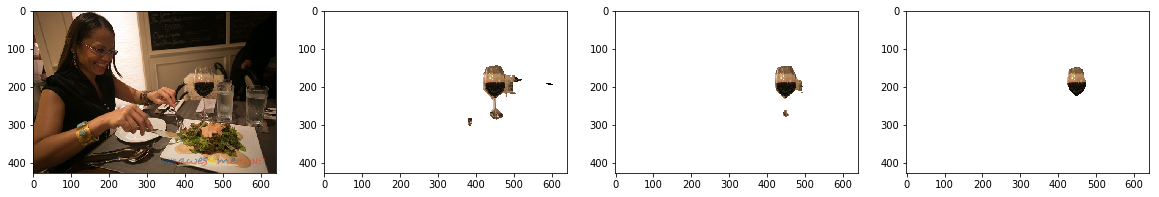

In [63]:
thresholds = [0, 0.5, 0.8]
for i in range(len(imgs)):
    preds = apreds[i]
    img = imgs[i]
    conf = confs[i]
    object_result = preds['object']
    object_conf = conf['object']
    img_np = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.imshow(img_np)
#     plt.show()
    for oix in np.unique(object_result):
        ps = []
        bs= [img_np.copy() for _ in threshold]
        for i, t in enumerate(thresholds):
            object_mask = (object_result != oix) + ((object_result == oix) * (object_conf < t))
            p = 1 - object_mask.sum() / (object_mask.shape[0] * object_mask.shape[1])
            bs[i][object_mask] = 255
            ps.append(p)
#         b[object_mask] = 255
        if ps[-1] < 0.01:
            continue
        ps = ' '.join(['%.1f%%' % p for p in ps])
        print(broden_dataset.names['object'][oix], ps)
        fig=plt.figure(figsize=(20, 10))
        fig.add_subplot(1, len(bs) + 1, 1)
        plt.imshow(img_np)
        for i, b in enumerate(bs, start=2):
            fig.add_subplot(1, len(bs) + 1, i)
            plt.imshow(b)
        plt.show()
    print()
    print()


In [183]:
    img_part_pred, part_result = img.copy(), preds['part']
    valid_object = np.zeros_like(object_result)
    present_obj_labels = np.unique(object_result)


person
-


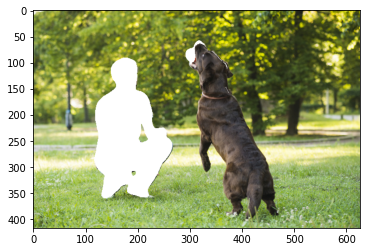

leg


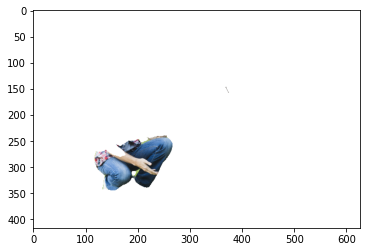

head


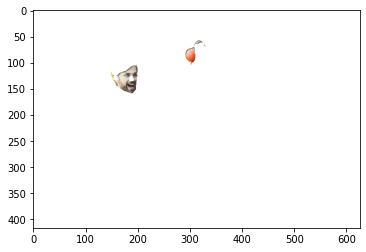

torso


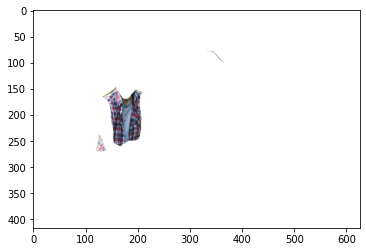

arm


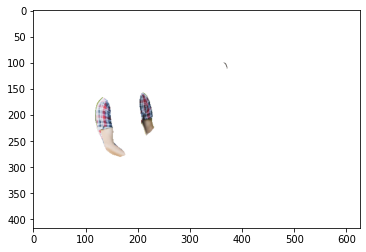

ear


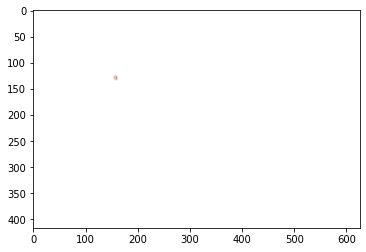

nose


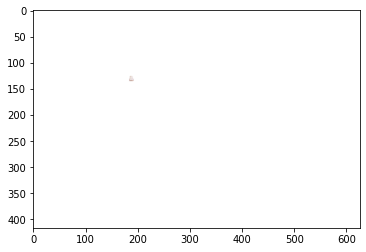

neck


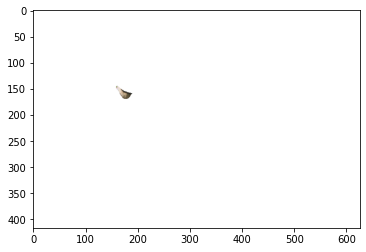

hand


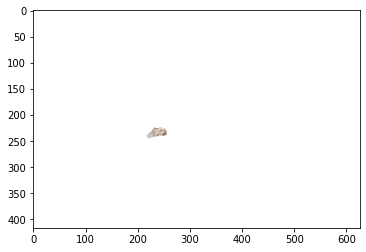

hair


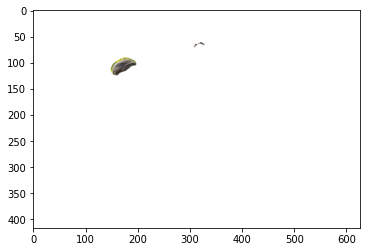

foot


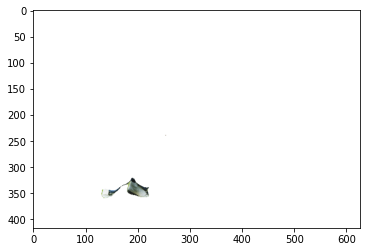

['-', 'leg', 'head', 'torso', 'arm', 'ear', 'nose', 'neck', 'hand', 'hair', 'foot']
dog
-


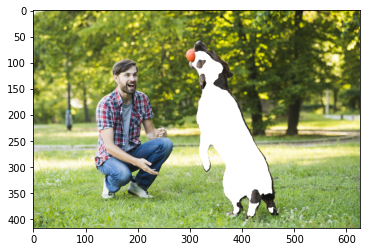

leg


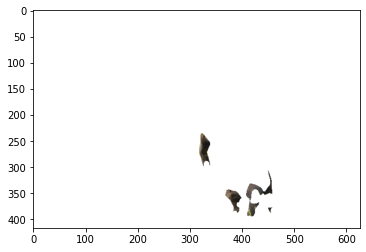

head


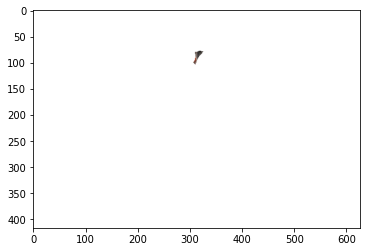

torso


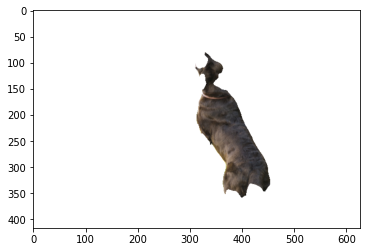

neck


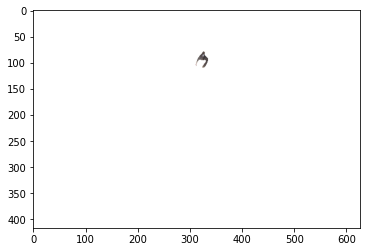

tail


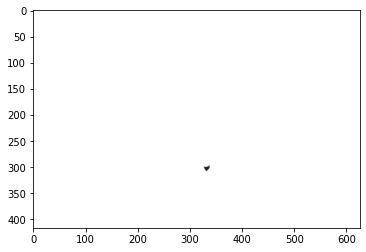

muzzle


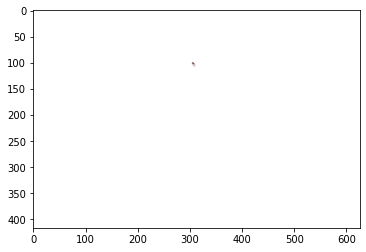

paw


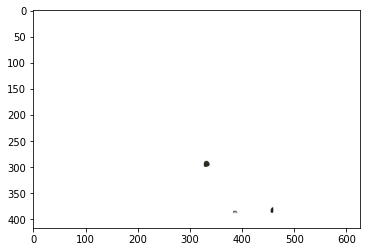

['-', 'leg', 'head', 'torso', 'neck', 'tail', 'muzzle', 'paw']
bird
-


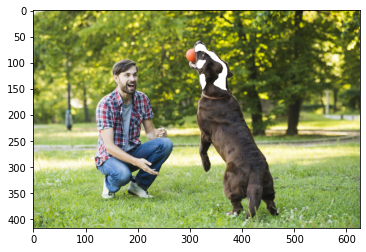

head


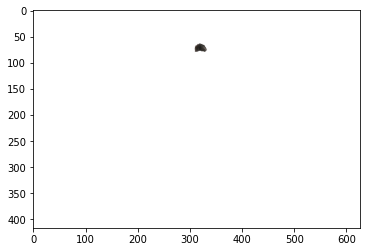

torso


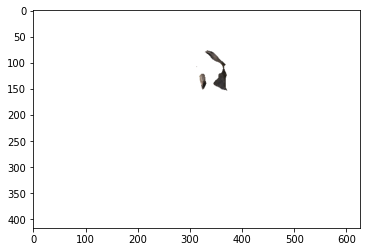

neck


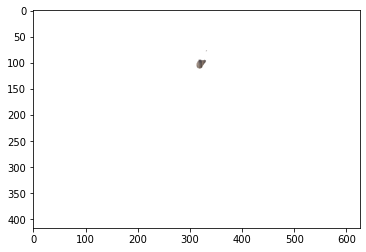

wing


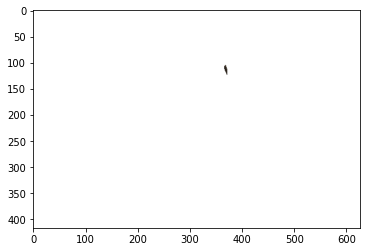

beak


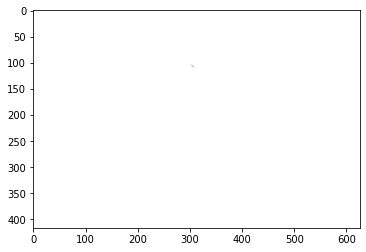

['-', 'head', 'torso', 'neck', 'wing', 'beak']
horse
-


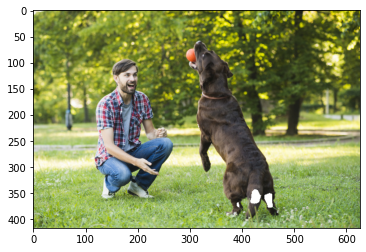

leg


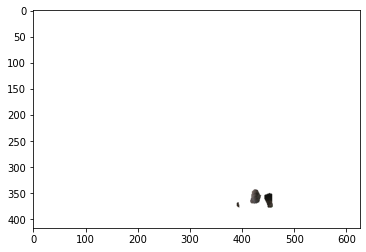

torso


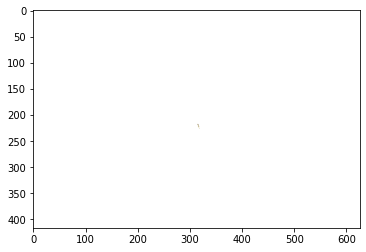

['-', 'leg', 'torso']


In [184]:
    img_np = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for obj_part_index, object_label in enumerate(broden_dataset.object_with_part):
        if object_label not in present_obj_labels:
            continue
        object_mask = (object_result == object_label)
        valid_object += object_mask
#         print(broden_dataset.names['object'][obj_part_index])
        part_result_masked = part_result[obj_part_index] * object_mask
        present_part_label = np.unique(part_result_masked)
        if len(present_part_label) == 1:
            continue
        print(broden_dataset.names['object'][object_label])
        for m in present_part_label:
            print(broden_dataset.names['part'][broden_dataset.object_part[object_label][m]])
            b = img_np.copy()
            b[part_result_masked!= m] = 255
            plt.imshow(b)
#             b = part_result_masked.copy()
#             b[b!=m] = 0
#             plt.imshow(skimage.segmentation.mark_boundaries(img_np, b))
            plt.show()
        print([broden_dataset.names['part'][broden_dataset.object_part[object_label][i]] for i in present_part_label])
        img_part_pred = maskrcnn_colorencode(img_part_pred, part_result_masked + object_mask, color_list)

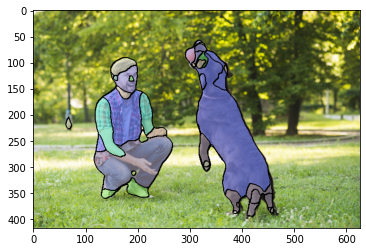

In [185]:
plt.imshow(cv2.cvtColor(img_part_pred, cv2.COLOR_BGR2RGB))

In [131]:
material_result = preds['material']
# img_material_result = maskrcnn_colorencode(
#     img, remove_small_mat(material_result * (valid_object > 0), object_result), color_list)


In [132]:
import skimage
import skimage.segmentation

In [144]:
# b != m.shape

ceramic


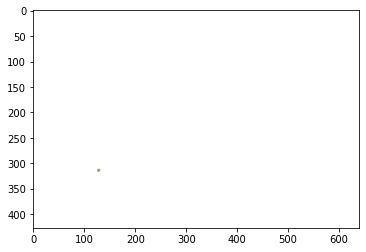

fabric


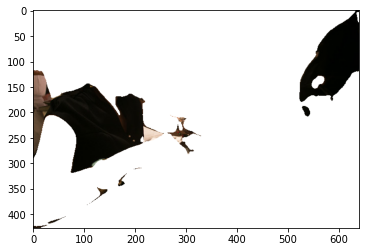

glass


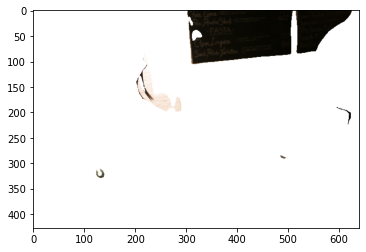

hair


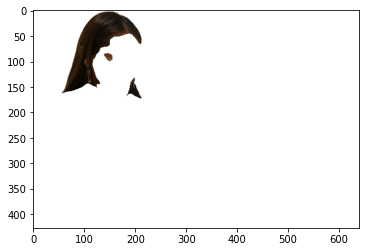

metal


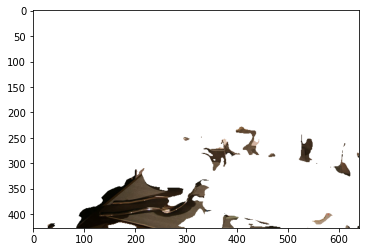

painted


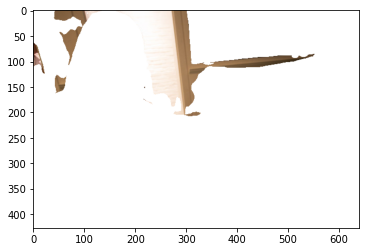

plastic


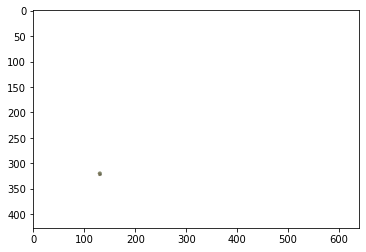

skin


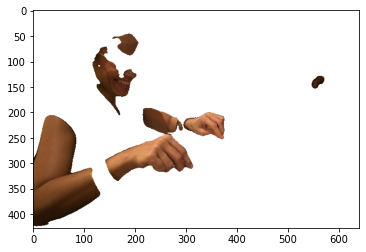

wood


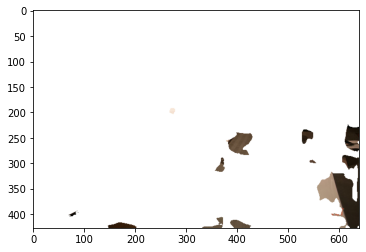

In [147]:
img_np = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
a = remove_small_mat(material_result * (valid_object > 0), object_result)
for m in np.unique(a):
    if m == 0:
        continue
    print(broden_dataset.names['material'][m])
#     b = a.copy()
#     b[b!= m] = 0
    b = img_np.copy()
    b[a!= m] = 255
    plt.imshow(b)
#     plt.imshow(skimage.segmentation.mark_boundaries(img_np, b))
    plt.show()

In [134]:
img_material_result = maskrcnn_colorencode(
        img, remove_small_mat(material_result * (valid_object > 0), object_result), color_list)


In [135]:
broden_dataset.names['material']

['-',
 'brick',
 'cardboard',
 'carpet',
 'ceramic',
 'fabric',
 'foliage',
 'food',
 'fur',
 'glass',
 'hair',
 'laminate',
 'leather',
 'metal',
 'mirror',
 'painted',
 'paper',
 'plastic',
 'polished stone',
 'rubber/latex',
 'skin',
 'stone',
 'tile',
 'wallpaper',
 'wicker',
 'wood']

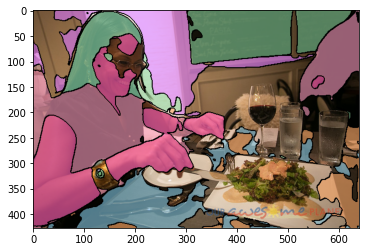

In [136]:
plt.imshow(cv2.cvtColor(img_material_result, cv2.COLOR_BGR2RGB))